In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from xgboost import XGBRegressor, XGBRFRegressor
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_ff3(val_start_date=None):
    ff3 = pd.read_csv('ff3_daily.csv')
    
    if val_start_date is not None:
        ff3 = ff3[ff3['date'] >= val_start_date]
        
    ff3 = ff3.reset_index(drop=True)
    ff3.index = ff3['date']
    ff3 = ff3.drop(columns=['date'])
    
    return ff3

def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # tf.compat.v1.set_random_seed(seed_value)
    torch.manual_seed(seed_value)
    return

def io_day_n_lag(data, n):
    # for each column in data, create five lags
    y = data.iloc[n:,:].reset_index(drop=True)    
    
    X = pd.DataFrame()

    for i in range(1, n+1):
        temp = data.shift(i).reset_index(drop=True)
        temp.columns = [f'{col}_lag{i}' for col in temp.columns]
        X = pd.concat([X, temp], axis=1)
    
    X = X.iloc[n:,:].reset_index(drop=True)
    
    return X, y

# def io_day_1_lag_second_order_input(data):
#     # Create input output pairs where input data includes second order interactions
#     X, y = io_day_1_lag(data)
#     cols = X.columns

#     for i in range(len(cols)):
#         for j in range(i+1, len(cols)):
#             col_name = cols[i] + cols[j]
#             col_values = X[cols[i]] * X[cols[j]]
#             X[col_name] = col_values
#     return X, y

def predictions_to_returns(pred_df, y, weighted=True):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions (in form [0, 1, 0, 0, 0])
    if weighted:
        strat_df = pred_df.apply(lambda row : weighted_predicted_factor_strat(row), axis = 1)
    else:
        strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector

def weighted_predicted_factor_strat(row):
    pos_preds = [x for x in row if x > 0]
    neg_preds = [x for x in row if x < 0]
    pos_sum = sum(pos_preds)
    neg_sum = abs(sum(neg_preds))
    row_list = [0]*len(row)
    for i in range(len(row)):
        if row[i] > 0:
            row_list[i] = row[i] / pos_sum
        elif row[i] < 0:
            row_list[i] = row[i] / neg_sum
    return pd.Series(row_list)
    

def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

In [3]:
class MultiLayerLSTM(nn.Module):
    def __init__(self, input_size, output_size, params=None):
        super(MultiLayerLSTM, self).__init__()
        
        self.hidden_sizes = params["hidden_sizes"] if params and "hidden_sizes" in params else [50]
        self.dropout = params["dropout"] if params and "dropout" in params else 0
        self.activation_fn = params["activation_fn"] if params and "activation_fn" in params else nn.ReLU()
        
        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_size, self.hidden_sizes[0], dropout=self.dropout, bidirectional=True, batch_first=True))
        
        for i in range(1, len(self.hidden_sizes)):
            self.lstm_layers.append(nn.LSTM(self.hidden_sizes[i-1] * 2, self.hidden_sizes[i], dropout=self.dropout, bidirectional=True, batch_first=True))
            
        self.output_layer = nn.Linear(self.hidden_sizes[-1] * 2, output_size)
    
    def forward(self, x):
        h_t = x
        for lstm_layer in self.lstm_layers:
            h_t, _ = lstm_layer(h_t)
            h_t = h_t[:, -1, :]
            h_t = self.activation_fn(h_t)
        
        # Only use the output of the last LSTM layer
        out = self.output_layer(h_t)
        return out

In [4]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, output_size, params=None):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.hidden_size = params["hidden_size"] if params and "hidden_size" in params else 50
        self.num_layers = params["num_layers"] if params and "num_layers" in params else 1
        self.dropout = params["dropout"] if params and "dropout" in params else 0
        self.activation_fn = params["activation_fn"] if params and "activation_fn" in params else nn.ReLU()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc_linear =  nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.activation_fn(hn)
        out = self.fc_linear(out)
        return out

In [5]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleFeedForwardNN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        print(f"number of hidden layers: {len(hidden_sizes)}")
    def forward(self, x):
        for layer in self.hidden_layers:
            x = nn.functional.relu(layer(x))
        x = self.output_layer(x)
        return x

In [6]:
def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, lr, batch_size, weighting_type, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "lr": lr,
        "batch_size": batch_size,
        "weighting_type": weighting_type
    }
    try:
        torch.save(checkpoint, path)
        print(f"Checkpoint saved at {path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
    
def load_checkpoint_from_path(path, input_size, output_size, model_type=SimpleLSTM, model_params=None):
    print(f"Loading checkpoint from {path}.pt")\
            
    checkpoint = torch.load(path)
    model = model_type(input_size, output_size, params=model_params)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=checkpoint['lr'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    
    print(f"Checkpoint loaded. ")
    
    return model, optimizer, train_losses, val_losses

def load_model_LSTM(path):
    final_save = torch.load(path)
    
    model_state_dict = final_save["model_state_dict"]
    model_params = final_save["model_params"]
    model_type = final_save["model_type"]
    input_size = final_save["input_size"]
    output_size = final_save["output_size"]
    
    model = model_type(input_size, output_size, params=model_params)
    model.load_state_dict(model_state_dict)
    
    return model

def load_model_xgb(path):
    final_save = torch.load(path)
    
    model = final_save['model']
    
    return model

In [7]:
def train_model_LSTM(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        num_epochs=50, 
        batch_size=32, 
        logging=True, 
        save_epochs=None, 
        final_save_path=None,
        checkpoints_dir=None, 
        load_checkpoint=None,
        model_params=None,
        model_type=SimpleLSTM):
    if (save_epochs and not checkpoints_dir) or (checkpoints_dir and not save_epochs):
        raise ValueError("Both save_epochs and checkpoints_dir must be provided if one is provided")
    elif checkpoints_dir:
        os.makedirs(checkpoints_dir, exist_ok=True)
    
    # Prapare datasets
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Calculate weights for each datapoint (closer to the end of the dataset, the more weight it has)
    def calc_weights():
        weights = torch.ones(len(y_train))
        for i in range(len(y_train)):
            weights[i] += 0.5 * (i / len(y_train))**2
        weights = weights / weights.sum()
        return weights
    # weights = calc_weights()
    weights = torch.ones(len(y_train))
    
    # model = Sequential()
    # model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(6, activation='linear'))
    # model.compile(loss='mean_squared_error', optimizer='adam')
    # model.fit(X_train, y_train, batch_size=32, epochs=50,
    #           validation_data=(X_val, y_val), verbose=2)
    
    # Define LSTM model
    input_size = X_train.shape[-1]  # Number of features
    output_size = y_train.shape[-1]  # Number of output features
    start_epoch = 1
    if load_checkpoint and checkpoints_dir:
        model, optimizer, train_losses, val_losses = load_checkpoint_from_path(checkpoints_dir+f'/epoch{load_checkpoint}.pt', input_size, output_size, model_params=model_params)
        
    elif load_checkpoint and not checkpoints_dir:
        raise ValueError("If load_checkpoint is provided, checkpoints_dir must also be provided")
    else:
        model = model_type(input_size, output_size, params=model_params)
        
        # Loss and optimizer
        lr = 1e-3
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
        train_losses = []
        val_losses = []
    
    loss_fn = nn.MSELoss()
        
    for epoch in range(start_epoch, num_epochs+1):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            # loss = (loss * weights).mean()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch)
                loss = loss_fn(val_outputs, y_val_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        if logging:
            print(f'Epoch [{epoch}/{num_epochs}]')
            print(f'\tTraining Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        elif save_epochs and epoch % save_epochs == 0 and not logging:
            print(f'Epoch [{epoch}/{num_epochs}]')
            print(f'\tTraining Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        if save_epochs and epoch % save_epochs == 0:
            weighting_type = 'equal'
            save_checkpoint(model, optimizer, epoch, train_losses, val_losses, lr, batch_size, weighting_type, f'{checkpoints_dir}/epoch{epoch}.pt')
        
        print()
    
    if final_save_path:
        final_save = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "lr": lr,
            "batch_size": batch_size,
            "weighting_type": 'equal',
            "model_params": model_params,
            "model_type": model_type,
            "input_size": input_size,
            "output_size": output_size,
            "num_epochs": num_epochs
        }
        torch.save(final_save, final_save_path)
    
    return model

In [8]:
def train_model_xgb(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        final_save_path=None, 
        model_type=XGBRegressor):
    
    model = model_type(objective='reg:squarederror', device='cuda')
    model.fit(X_train, y_train)
    
    print(f"Train MSE: {mean_squared_error(y_train, model.predict(X_train))}")
    print(f"Validation MSE: {mean_squared_error(y_val, model.predict(X_val))}")
    
    if final_save_path:
        final_save = {
            "model": model
        }
        torch.save(final_save, final_save_path)
    
    return model

In [9]:
def preprocess_data_LSTM(data, io_fn, seq_len, test_size_split=0.1):
    X, y = io_fn(data, seq_len)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size_split, shuffle=False)
    
    X_train = X_train.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_train = y_train.drop(columns=['date'])
    X_val = X_val.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_val = y_val.drop(columns=['date'])
    
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')
    y_val = y_val.apply(pd.to_numeric, errors='coerce')
    
    # Convert X_train of shape (n_samples, n_features) to (n_samples, seq_len, n_features)
    X_train = X_train.values.reshape(X_train.shape[0], seq_len, X_train.shape[1] // seq_len)[:, ::-1, :]
    y_train = y_train.values
    X_val = X_val.values.reshape(X_val.shape[0], seq_len, X_val.shape[1] // seq_len)[:, ::-1, :]
    y_val = y_val.values
    
    X_train = np.ascontiguousarray(X_train)
    X_val = np.ascontiguousarray(X_val)
    
    val_start_date = int(data.iloc[len(X_train)+seq_len]['date'])
    
    return X_train, y_train, X_val, y_val, val_start_date

def preprocess_data_xgb(data, io_fn, seq_len, test_size_split=0.1):
    X, y = io_fn(data, seq_len)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size_split, shuffle=False)
    
    X_train = X_train.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_train = y_train.drop(columns=['date'])
    X_val = X_val.drop(columns=[f'date_lag{i}' for i in range(1, seq_len+1)])
    y_val = y_val.drop(columns=['date'])
    
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')
    y_val = y_val.apply(pd.to_numeric, errors='coerce')
    
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values
    
    val_start_date = int(data.iloc[len(X_train)+seq_len]['date'])
    
    print("X_train.shape, y_train.shape, X_val.shape, y_val.shape")
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
    print(f"seq_len: {seq_len}")
    
    
    return X_train, y_train, X_val, y_val, val_start_date

In [10]:
DATA_WEIGHING = "value"
NUM_INDUSTRIES = "ff6"
SEQ_LEN = 22

def get_data(num_industries=49, weight_type='value', seed = 519, io_fn = io_day_n_lag, seq_len = SEQ_LEN):
    all_data_paths = {
        "ff3": "ff3_daily.csv",
        "ff6": "ff6_daily.csv"
    }

    for n_ind in [5, 10, 12, 17, 30, 38, 48, 49]:
        for weight in ['equal', 'value']:
            all_data_paths[f"{n_ind}industries_{weight}"] = f"ff_industry_portfolios_daily_{weight}/{n_ind}_Industry_Portfolios_Daily.csv"

    if num_industries in ['ff3', 'ff6']:
        data_path = all_data_paths[num_industries]
    else:
        data_path = all_data_paths[f'{num_industries}industries_{weight_type}']

    data = pd.read_csv(data_path)
    data = data.dropna()

    if seed is not None:
        set_seed(seed)

    return data, io_fn, seq_len, all_data_paths

In [11]:
models_dirs = ["models/max", "models/weighted"]
_, io_fn, seq_len, all_data_paths = get_data(num_industries=NUM_INDUSTRIES, weight_type=DATA_WEIGHING)

def predict_LSTM(model, X_val):
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(np.zeros((X_val.shape[0], X_val.shape[-1])), dtype=torch.float32)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32)

    with torch.no_grad():
        pred_df = torch.tensor([])
        for X_val_batch, _ in val_loader:
            val_outputs = model(X_val_batch)
            
            pred_df = torch.cat((pred_df, val_outputs), 0)
            
        pred_df = pd.DataFrame(pred_df.numpy())

    return pred_df

def predict_xgboost(model, X_val):
    return pd.DataFrame(model.predict(X_val))

def evaluate_model_LSTM(save_path, data_path, weighted=True, print_summary=True):
    data = pd.read_csv(data_path)
    data = data.dropna()
    
    _, _, X_val, y_val, val_start_date = preprocess_data_LSTM(data, io_fn, seq_len)
    
    model = load_model_LSTM(save_path)
    pred_df = predict_LSTM(model, X_val)
    print(pred_df.shape)
    
    strat_df, strat_ret_vec = predictions_to_returns(pred_df, y_val, weighted=weighted)

    ff3 = load_ff3(val_start_date)
    strat_ret_vec.index = ff3.index

    # Calculate alpha
    y_ols = sm.add_constant(ff3[['Mkt-RF','SMB', 'HML']])
    model_OLS = sm.OLS(strat_ret_vec, y_ols).fit()
    if print_summary:
        print(f"Alpha: {model_OLS.params['const']:.3f} ({(np.power(1 + model_OLS.params['const']/100, 22*12) - 1) * 100:.2f}% annually)")
        print(f"Alpha p-value: {model_OLS.pvalues['const']:.3f}")
        print(f"Beta: {model_OLS.params['Mkt-RF']:.3f}")
        print(f"Beta p-value: {model_OLS.pvalues['Mkt-RF']:.3f}")
    
    mkt_ret_vec = ff3['Mkt-RF']
    
    return strat_ret_vec, mkt_ret_vec

def evaluate_model_xgb(save_path, data_path, weighted=True, print_summary=True):
    data = pd.read_csv(data_path)
    data = data.dropna()
    
    _, _, X_val, y_val, val_start_date = preprocess_data_xgb(data, io_fn, seq_len)
    
    model = load_model_xgb(save_path)
    pred_df = predict_xgboost(model, X_val)
    
    strat_df, strat_ret_vec = predictions_to_returns(pred_df, y_val, weighted=weighted)

    ff3 = load_ff3(val_start_date)
    strat_ret_vec.index = ff3.index

    # Calculate alpha
    y_ols = sm.add_constant(ff3[['Mkt-RF','SMB', 'HML']])
    model_OLS = sm.OLS(strat_ret_vec, y_ols).fit()
    if print_summary:
        print(f"Alpha: {model_OLS.params['const']:.3f} ({(np.power(1 + model_OLS.params['const']/100, 22*12) - 1) * 100:.2f}% annually)")
        print(f"Alpha p-value: {model_OLS.pvalues['const']:.3f}")
        print(f"Beta: {model_OLS.params['Mkt-RF']:.3f}")
        print(f"Beta p-value: {model_OLS.pvalues['Mkt-RF']:.3f}")
    
    strat_ret_vec = strat_ret_vec + ff3['RF']
    mkt_ret_vec = ff3['Mkt-RF'] + ff3['RF']
    
    return strat_ret_vec, mkt_ret_vec

def show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='Strategy', log_scale=False, get_cum_strat_rets=False):
    cum_strat_rets = (1 + strat_ret_vec/100).cumprod()
    cum_mkt_rets = (1 + mkt_ret_vec/100).cumprod()
    
    cum_mkt_rets.index = pd.to_datetime(cum_mkt_rets.index, format='%Y%m%d')
    cum_mkt_rets_monthly = cum_mkt_rets.resample('M').last()
    
    cum_strat_rets.index = pd.to_datetime(cum_strat_rets.index, format='%Y%m%d')
    cum_strat_rets_monthly = cum_strat_rets.resample('M').last()
    
    # Plot the cumulative returns
    plt.plot(cum_strat_rets_monthly, label=strategy_name)
    plt.plot(cum_mkt_rets_monthly, label='Market')

    if log_scale:
        plt.yscale('log')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()
    
    if get_cum_strat_rets:
        return cum_strat_rets

In [12]:
def chosen_strats_LSTM(save_path, data_path):
    data = pd.read_csv(data_path)
    data = data.dropna()
        
    _, _, X_val, y_val, _ = preprocess_data_LSTM(data, io_fn, seq_len)
        
    model = load_model_LSTM(save_path)
    pred_df = predict_LSTM(model, X_val)
    
    strat_df, _ = predictions_to_returns(pred_df, y_val)
    strat_df.columns = data.columns[1:]

    return strat_df

def chosen_strats_xgb(save_path, data_path):
    data = pd.read_csv(data_path)
    data = data.dropna()
        
    _, _, X_val, y_val, _ = preprocess_data_xgb(data, io_fn, seq_len)
        
    model = load_model_xgb(save_path)
    pred_df = predict_xgboost(model, X_val)
    
    strat_df, _ = predictions_to_returns(pred_df, y_val)
    strat_df.columns = data.columns[1:]

    return strat_df

In [13]:
def model_strat_distribution(model_path: str, data_path, data_weighing = None):
    idx = model_path.find("industries")
    if idx != -1:
        strat = model_path[idx-2:idx] # 5, 10, 12, 17, 30, 38, 48, 49
        data_weighing = model_path[idx+11:idx+16] # equal or value
        data_path = all_data_paths[f'{strat}industries_{data_weighing}']
    else:
        strat = model_path[-6: -3] # ff3 or ff6
        data_path = all_data_paths[strat]
    
    data, _, _, _ = get_data(strat, data_weighing)
    
    if "LSTM" in model_path:
        model = load_model_LSTM(model_path)
        strat_df = chosen_strats_LSTM(model_path, data_path)
    elif "XGB" in model_path:
        model = load_model_xgb(model_path)
        strat_df = chosen_strats_xgb(model_path, data_path)
    else:
        raise ValueError("Model path must contain 'LSTM' or 'XGB'")
        
    print("=====================================================================================================")
    print(f"Model: {model_path}")
    print("=====================================================================================================")

    # create a dictionary from column names of strat_df
    strat_dist = {col: 0 for col in strat_df.columns}
    num_rows = len(strat_df)
    
    
    for row in strat_df.iterrows():
        # get the column name of the max value in the row
        max_strat_name = row[1][row[1] == True].index[0]
        strat_dist[max_strat_name] += 1
    
    strat_dist = dict(sorted(strat_dist.items(), key=lambda item: item[1], reverse=True))
    
    print("Most chosen strategies:")
    for key in strat_dist.keys():
        print(f"{key}: {strat_dist[key]/num_rows*100:.0f}%", end=", ")
    print()
    print()
    
    return strat_dist

In [14]:
def preprocess_data(data, io_fn, seq_len, model_type):
    if model_type == SimpleLSTM or model_type == MultiLayerLSTM:
        return preprocess_data_LSTM(data, io_fn, seq_len)
    elif model_type == XGBRegressor or model_type == XGBRFRegressor:
        return preprocess_data_xgb(data, io_fn, seq_len)
    else:
        raise ValueError("Invalid model type")

In [15]:
def train_model(
    model_type,
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    num_epochs=50, 
    batch_size=32, 
    logging=True, 
    save_epochs=None, 
    final_save_path=None,
    checkpoints_dir=None, 
    load_checkpoint=None,
    model_params=None):
    if model_type == SimpleLSTM or model_type == MultiLayerLSTM:
        return train_model_LSTM(
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            num_epochs=num_epochs, 
            batch_size=batch_size, 
            logging=logging, 
            save_epochs=save_epochs, 
            final_save_path=final_save_path,
            checkpoints_dir=checkpoints_dir, 
            load_checkpoint=load_checkpoint,
            model_params=model_params,
            model_type=model_type)
    elif model_type == XGBRegressor or model_type == XGBRFRegressor:
        return train_model_xgb(
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            final_save_path=final_save_path, 
            model_type=model_type)
    else:
        raise ValueError("Invalid model type")

In [16]:
def train_all_models(
    model_types,
    ret_weighing_types,
    industries_list,
    io_fn,
    seq_len,
    num_epochs=50,
    batch_size=32,
    logging=False,
    save_epochs=None,
    final_save_path=None,
    checkpoints_dir=None,
    model_params=None):
    
    for model_type in model_types:
        for num_industries in industries_list:
            for data_weighing in ["equal", "value"]:
                for ret_weighing_type in ret_weighing_types:
                    # there is no 'equal' vs 'value' for ff3 and ff6
                    if num_industries in ['ff3', 'ff6'] and data_weighing == 'value':
                        pass
                    data, _, _, _ = get_data(num_industries, data_weighing)
                    X_train, y_train, X_val, y_val, val_start_date = preprocess_data(data, io_fn, seq_len, model_type)
                    print("X_train shape:\t", X_train.shape)
                    print("y_train shape:\t", y_train.shape)
                    print("X_val shape:\t", X_val.shape)
                    print("y_val shape:\t", y_val.shape)
                    print("val_start_date:\t", val_start_date)
                    
                    print(f"Training {model_type} on {num_industries} industries with {data_weighing} weighting")
                    
                    model_file_name = f"{model_type.__name__}_{seq_len}days_{num_industries}"
                    if num_industries not in ['ff3', 'ff6']:
                        model_file_name += f"industries_{data_weighing}"
                    
                    model = train_model(
                                model_type,
                                X_train, 
                                y_train,
                                X_val,
                                y_val,
                                num_epochs,
                                batch_size,
                                logging=logging, 
                                save_epochs=save_epochs,
                                final_save_path=f"{final_save_path}/{ret_weighing_type}/{model_file_name}.pt",
                                checkpoints_dir=f"{checkpoints_dir}/{ret_weighing_type}/{model_file_name}",
                                model_params=model_params)
                    
                    print(f"Training complete. Saved {model_file_name} to {final_save_path}/{ret_weighing_type}")

In [17]:
# seq_len = 22
# io_fn = io_day_n_lag
# model_type = SimpleLSTM
# num_industries = 'ff6'
# data_weighing = 'value'
# num_epochs = 50
# batch_size = 32
# logging = False
# save_epochs = 10
# final_save_path = "models"
# checkpoints_dir = "checkpoints"
# model_params = {
#     "hidden_size": 50,
#     "num_layers": 1,
#     "dropout": 0.2,
#     "activation_fn": nn.ReLU()
# }
# ret_weighing_type = "weighted"

# data, _, _, _ = get_data('ff6', 'value')
# X_train, y_train, X_val, y_val, val_start_date = preprocess_data(data, io_fn, seq_len, model_type)
# print("X_train shape:\t", X_train.shape)
# print("y_train shape:\t", y_train.shape)
# print("X_val shape:\t", X_val.shape)
# print("y_val shape:\t", y_val.shape)
# print("val_start_date:\t", val_start_date)

# print(f"Training {model_type} on {num_industries} industries with {data_weighing} weighting")

# model_file_name = f"{model_type.__name__}_{seq_len}days_{num_industries}"
# if num_industries not in ['ff3', 'ff6']:
#     model_file_name += f"industries_{data_weighing}"

# model = train_model(
#             model_type,
#             X_train, 
#             y_train,
#             X_val,
#             y_val,
#             num_epochs,
#             batch_size,
#             logging=logging, 
#             save_epochs=save_epochs,
#             final_save_path=f"{final_save_path}/{ret_weighing_type}/{model_file_name}.pt",
#             checkpoints_dir=f"{checkpoints_dir}/{ret_weighing_type}/{model_file_name}",
#             model_params=model_params)

# print(f"Training complete. Saved {model_file_name} to {final_save_path}/{ret_weighing_type}")

In [18]:
SEQ_LEN = 5
data, io_fn, seq_len, all_data_paths = get_data(NUM_INDUSTRIES, weight_type=DATA_WEIGHING, seq_len = SEQ_LEN)

(1529, 7)
Alpha: 0.087 (25.70% annually)
Alpha p-value: 0.016
Beta: -0.068
Beta p-value: 0.015


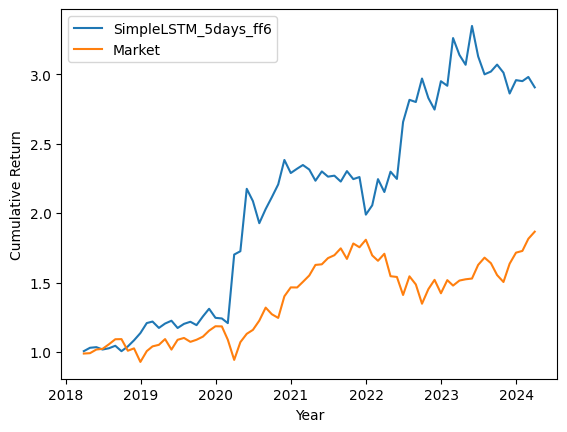

In [19]:
# model_strat_distribution("models/weighted/SimpleLSTM_5days_ff6.pt", all_data_paths['ff6'])
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM(f'models/weighted/SimpleLSTM_{SEQ_LEN}days_ff6.pt', all_data_paths['ff6'], print_summary='short', weighted=True)
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'SimpleLSTM_{SEQ_LEN}days_ff6', log_scale=False)

(1529, 7)
Alpha: 0.024 (6.50% annually)
Alpha p-value: 0.371
Beta: 0.292
Beta p-value: 0.000


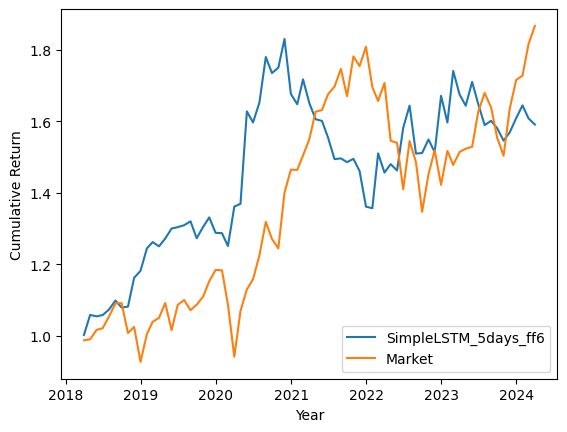

In [20]:
# model_strat_distribution("models/weighted/SimpleLSTM_5days_ff6.pt", all_data_paths['ff6'])
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/max/SimpleLSTM_5days_ff6.pt', all_data_paths['ff6'], print_summary='short', weighted=False)
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='SimpleLSTM_5days_ff6', log_scale=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape
(13756, 35) (13756, 7) (1529, 35) (1529, 7)
seq_len: 5
Alpha: 0.038 (10.68% annually)
Alpha p-value: 0.198
Beta: -0.029
Beta p-value: 0.215


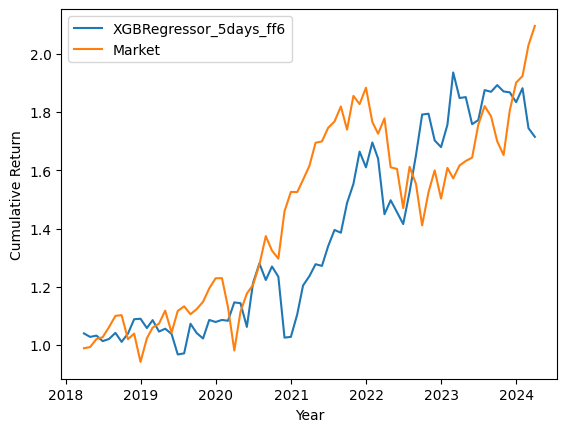

In [21]:
# model_strat_distribution('models/weighted/XGBRegressor_5days_ff6.pt', all_data_paths['ff6'])
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb('models/weighted/XGBRegressor_5days_ff6.pt', all_data_paths['ff6'], weighted=True, print_summary='short')
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='XGBRegressor_5days_ff6', log_scale=False)

(2571, 38)
Alpha: 99.912 (2639492789770050414649330872474272201141213114512540278123941943718209618643517440.00% annually)
Alpha p-value: 0.000
Beta: 0.898
Beta p-value: 0.000


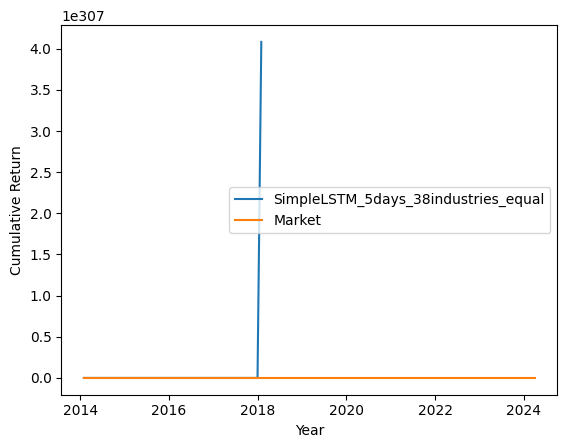

(2571, 10)
Alpha: -0.037 (-9.25% annually)
Alpha p-value: 0.094
Beta: 0.142
Beta p-value: 0.000


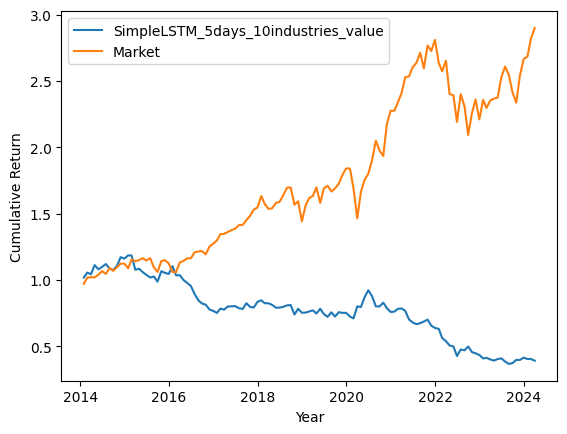

In [25]:
# model_strat_distribution('models/weighted/SimpleLSTM_5days_10industries_equal.pt', all_data_paths['10industries_equal'], data_weighing='equal')
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/weighted/SimpleLSTM_5days_38industries_equal.pt', all_data_paths['38industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='SimpleLSTM_5days_38industries_equal', log_scale=False)

# model_strat_distribution('models/weighted/SimpleLSTM_5days_10industries_value.pt', all_data_paths['10industries_value'], data_weighing='value')
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/weighted/SimpleLSTM_5days_10industries_value.pt', all_data_paths['10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='SimpleLSTM_5days_10industries_value', log_scale=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape
(23134, 50) (23134, 10) (2571, 50) (2571, 10)
seq_len: 5
Alpha: 0.003 (0.90% annually)
Alpha p-value: 0.848
Beta: 0.077
Beta p-value: 0.000


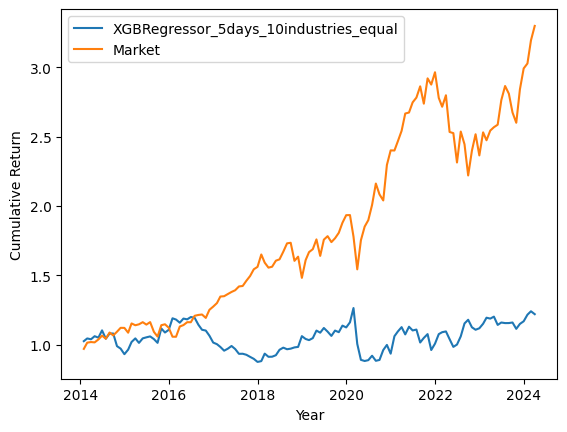

X_train.shape, y_train.shape, X_val.shape, y_val.shape
(23134, 50) (23134, 10) (2571, 50) (2571, 10)
seq_len: 5
Alpha: 0.005 (1.28% annually)
Alpha p-value: 0.781
Beta: 0.030
Beta p-value: 0.057


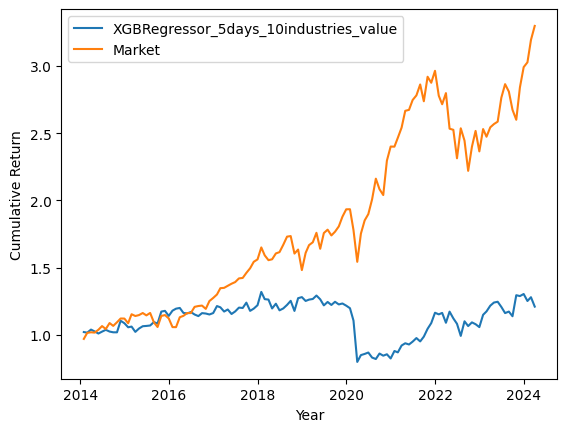

In [23]:
# model_strat_distribution('models/weighted/XGBRegressor_5days_ff6.pt', all_data_paths['ff6'])
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb('models/weighted/XGBRegressor_5days_10industries_equal.pt', all_data_paths['10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='XGBRegressor_5days_10industries_equal', log_scale=False)

# model_strat_distribution('models/weighted/XGBRegressor_5days_10industries_value.pt',
# all_data_paths['10industries_value'])
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb('models/weighted/XGBRegressor_5days_10industries_value.pt', all_data_paths['10industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='XGBRegressor_5days_10industries_value', log_scale=False)

In [24]:
# model_strat_distribution('models/weighted/SimpleLSTM_5days_49industries_equal.pt', all_data_paths['49industries_equal'], data_weighing='equal')
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM('models/weighted/SimpleLSTM_5days_49industries_equal.pt', all_data_paths['49industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='SimpleLSTM_5days_49industries_equal', log_scale=False)

# model_strat_distribution('models/weighted/SimpleLSTM_5days_49industries_value.pt', all_data_paths['49industries_value'], data_weighing='value')
strat_ret_vec, mkt_ret_vec = evaluate_model_LSTM(f'models/weighted/SimpleLSTM_5days_49industries_value.pt', all_data_paths[f'49industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name=f'SimpleLSTM_5days_49industries_value', log_scale=False)

KeyboardInterrupt: 

25705 25705
Alpha: -0.002 (-0.63% annually)
Alpha p-value: 0.872
Beta: 0.014
Beta p-value: 0.303


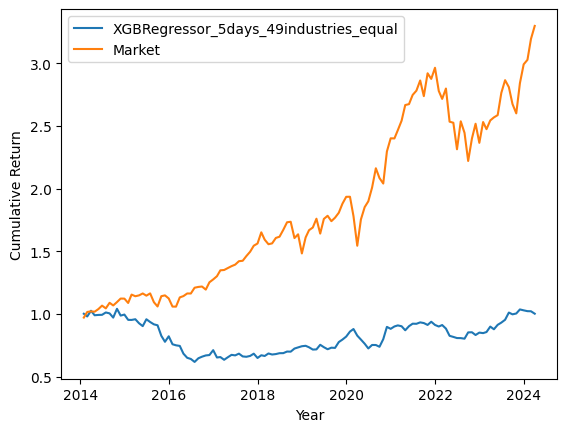

25705 25705
Alpha: 0.003 (0.70% annually)
Alpha p-value: 0.807
Beta: 0.022
Beta p-value: 0.022


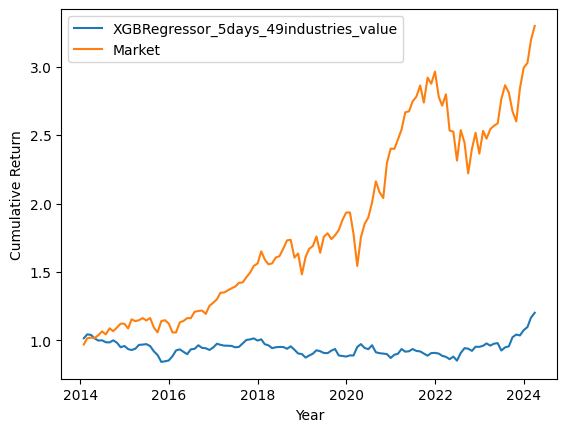

In [ ]:
# model_strat_distribution('models/weighted/XGBRegressor_5days_49industries_equal.pt', all_data_paths['49industries_equal'], data_weighing='equal')
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/weighted/XGBRegressor_5days_49industries_equal.pt', all_data_paths[f'49industries_equal'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='XGBRegressor_5days_49industries_equal', log_scale=False)

# model_strat_distribution('models/weighted/XGBRegressor_5days_49industries_value.pt', all_data_paths['49industries_value'], data_weighing='value')
strat_ret_vec, mkt_ret_vec = evaluate_model_xgb(f'models/weighted/XGBRegressor_5days_49industries_value.pt', all_data_paths[f'49industries_value'])
show_cumulative_returns(strat_ret_vec, mkt_ret_vec, strategy_name='XGBRegressor_5days_49industries_value', log_scale=False)